# 时间序列聚类

参考文献：

Experimental comparison of representation methods and distance measures for time series data

基于欧氏动态时间弯曲距离与熵权法的负荷曲线聚类方法

[Zhihu](https://zhuanlan.zhihu.com/p/87461784)

[Github](https://github.com/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb)

[某篇笔记](https://banxian-w.com/article/2022/1/20/2060.html)

[A blog](https://rtavenar.github.io/blog/dtw.html)

## 欧几里得距离(Euclidean distance)

The Euclidean distance between two time series $Q$ and $C$ of length $n$ is defined as

$$d(Q,C) = \sqrt{\sum^n_{i=1}[Q(i)-C(i)]^2}$$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math

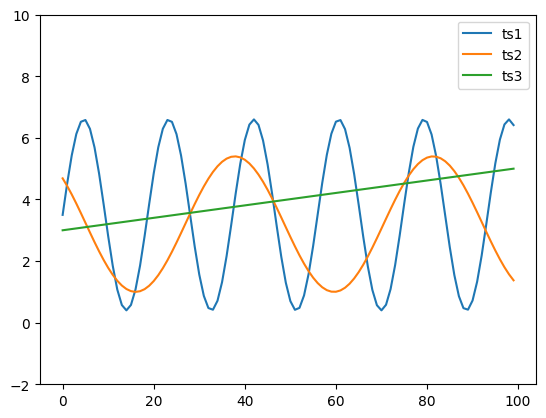

In [3]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

直观来看，ts1和ts2两个时间序列的“波动特性”比较相似，而ts3则为一条线段，看起来没有这么相似。

但是在Euclidean距离判定下，ts1和ts3的距离更加相近。当它遇到时间轴的扭曲时，它经常产生悲观的相似性度量。解决这个问题的方法是使用动态时间规整DTW。

In [4]:
def euclid_dist(ts1,ts2):
    return math.sqrt(sum((ts1-ts2)**2))

print(euclid_dist(ts1,ts2))
print(euclid_dist(ts1,ts3))

26.959216037969345
23.189249190311056


## 动态时间规整(Dynamic Time Warping)

欧氏距离计算序列逐点之间的距离来量度静态数据之间的相似性，但时间序列一般具有强动态特性，通过短时序平移之后高度重合的时间序列（称为**形态相似**）包含有相似的信息。特别是对于含新能源和新型负荷接入的微电网而言，**新能源功率与负荷功率形态上的相似性往往可能对应相似的运行策略**。因此，需要通过计算时间序列之间的形态距离来量度时间序列相似性。

DTW距离能够通过弯曲时间轴对时间序列进行匹配映射来计算形态相似性，对时间序列的形态相似性计算具有较好的精确性和鲁棒性

![alt text](../img/image.png)

Consider two time series $Q$ and $C$ of the same length $n$(长度不同也行)

$$
Q = q_1, q_2, ..., q_n \\

C = c_1, c_2, ..., c_n(c_m) \\
$$

可以得到一个距离矩阵 $D \in R^{n\times n}$，其中 $d_{ij}=(x_i-y_j)^2$。我们想通过这个矩阵找到一条使**累积距离最小的路径**。然后，该路径确定两个时间序列之间的**最佳对齐**。应该注意的是，一个时间序列中的一个点可能映射到另一个时间序列中的多个点。

接下来，定义时间序列$Q$, $C$的路径向量$W = w_1, w_2, ...,w_K$，$W$中元素代表着$Q$中某点和$C$中某点的距离，i.e. $w_k = (q_i - c_j)^2$

所以我们要找到具有最小欧氏距离的路径

$$
W^* = \argmin_w (\sqrt{\sum_{k=1}^{K}w_k})
$$

可以通过动态规划找到最优路径，特别是下面的递归函数（说白了，距离矩阵从左下角跑到右上角的最短路径，动态规划入门问题）

$$
\gamma(i,j)=d(q_i,c_j)+\min ( \gamma(i-1,j-1),\gamma(i-1,j),\gamma(i,j-1))
$$
 

In [5]:
def DTWDistance(ts1, ts2):
    DTW={}
    
    # initialization
    for i in range(len(ts1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(ts2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    # dp
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist= (ts1[i]-ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return math.sqrt(DTW[len(ts1)-1, len(ts2)-1])

现在ts1和ts2的距离更加接近，也更加符合直觉

In [6]:
print(DTWDistance(ts1,ts2))
print(DTWDistance(ts1,ts3))

17.929718468641138
21.549494824404572


## DTW算法加速

DTW算法复杂度是$O(nm)$，其中$n,m$是两个时间序列的长度

常见的两种全局约束方法（Sakoe-Chiba约束 和 Itakura-Parallelogram 约束）

![alt text](../img/image-1.png)

Sakoe-Chiba 约束：若$w_p=d_{ij}$，应有$|j-i|\leq w，r\in[\min(m,n),\max(m,n)]$。其中，$w$表示最大路径弯曲(窗口)长度，该约束有效限制时序数据之间单个点的最大连续对应数量，使得只有通过短时序平移之后高度重合的时间序列才会得到较小的形态距离。特别地，当$w=0$时，Sakoe-Chiba约束下的DTW距离等同于欧氏距离。

In [7]:
def cDTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

发现加了Sakoe-Chiba约束后，DTW距离并没有多大变化，并且在“风光”场景下加这个约束是合理的，可能每天偏差不超过2小时？那就是$w=1$的情况

In [8]:
print(cDTWDistance(ts1,ts2,10))
print(cDTWDistance(ts1,ts3,10))

18.59655183841726
22.47248284679103


另一种加快速度的方法是使用LB Keogh动态时间规整下界

$$
LBKeogh(Q,C)=\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i)\\

LBKeogh(Q,C) \leq DTW(Q,C)
$$

LB Keogh下界方法是线性的，而动态时间规整是二次的，这使得它在大时间序列集上的搜索非常有利。

In [9]:
def LB_Keogh(s1, s2, r):
    LB_sum = 0
    for ind, i in enumerate(s1):
        lower_bound = min(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])
        upper_bound = max(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])

        if i > upper_bound:
            LB_sum += (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum += (i - lower_bound) ** 2

    return math.sqrt(LB_sum)

In [10]:
print(LB_Keogh(ts1,ts2,20))
print(LB_Keogh(ts1,ts3,20))

6.253892351594148
19.959547869419758


### 测试两种加速区别

In [11]:
from sklearn.metrics import classification_report

def knn(train, test, w):
    preds = []
    for ind, i in enumerate(test):
        min_dist = float('inf')
        closest_seq = []
        # print ind
        for j in train:
            if LB_Keogh(i[:-1], j[:-1], 5) < min_dist:
                dist = cDTWDistance(i[:-1], j[:-1], w)
                if dist < min_dist:
                    min_dist = dist
                    closest_seq = j
        preds.append(closest_seq[-1])
    return classification_report(test[:, -1], preds)

In [12]:
train = np.genfromtxt('../data/train.csv', delimiter='\t')
test = np.genfromtxt('../data/test.csv', delimiter='\t')
print(knn(train, test, 4))

KeyboardInterrupt: 

In [ ]:
import random

def k_means_clust(data, num_clust, num_iter, w=5):
    centroids = random.sample(data, num_clust)
    counter = 0
    for n in range(num_iter):
        counter += 1
        print(counter)
        assignments = {}
        # assign data points to clusters
        for ind, i in enumerate(data):
            min_dist = float('inf')
            closest_clust = None
            for c_ind, j in enumerate(centroids):
                if LB_Keogh(i, j, 5) < min_dist:
                    cur_dist = cDTWDistance(i, j, w)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust] = []
    
        # recalculate centroids of clusters
        for key in assignments:
            clust_sum = 0
            for k in assignments[key]:
                clust_sum = clust_sum + data[k]
            centroids[key] = [m / len(assignments[key]) for m in clust_sum]
    
    return centroids

In [ ]:
import matplotlib.pylab as plt
data=np.vstack((train[:,:-1],test[:,:-1]))
centroids=k_means_clust(data,4,10,4)
for i in centroids:
    
    plt.plot(i)

plt.show()

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

## `tslearn` 库

调包结果完全一致，以后调包就行哈

In [14]:
import numpy as np
from tslearn.metrics import dtw

In [15]:
print(euclid_dist(ts1,ts2))
print(euclid_dist(ts1,ts3))
# tslearn
print(np.linalg.norm(ts1 - ts2))
print(np.linalg.norm(ts1 - ts3))

26.959216037969345
23.189249190311056
26.95921603796934
23.18924919031106


In [16]:
print(DTWDistance(ts1,ts2))
print(DTWDistance(ts1,ts3))
# tslearn
print(dtw(ts1,ts2))
print(dtw(ts1,ts3))

17.929718468641138
21.549494824404572
17.929718468641138
21.549494824404572


In [17]:
print(cDTWDistance(ts1,ts2,10))
print(cDTWDistance(ts1,ts3,10))
# tslearn
print(dtw(ts1,ts2, sakoe_chiba_radius=10))
print(dtw(ts1,ts3, sakoe_chiba_radius=10))

18.59655183841726
22.47248284679103
18.35300583827852
22.464384445968676
